In [1298]:
import os
import sys
import numpy as np
import pandas as pd
import joblib
import pickle

from scipy.stats import gmean
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler

# Transform data

## Load self-written transformers

In [187]:
MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project/')  # TODO load from CONFIG file
# MODULE_PATH = os.path.abspath(os.path.join('..'))
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

In [188]:
from utils.transformers import RCLRTransformer, CLRTransformer, Log1pMinMaxScaler, IdentityScaler
from utils.preprocessing import MicrobiomeDataPreprocessing

## Load data

In [189]:
MAIN_PATH = Path("/storage/zkarwowska/microbiome-interactions/")  # TODO load from CONFIG file
# After rerefaction (OBSOLETE)
# INPUT_PATH = MAIN_PATH / "datasets/processed/ready_datasets"
# Without rerefaction but with PCHIP interpolation
INPUT_PATH = MAIN_PATH / "datasets/processed/ready_datasets_no_rarefaction"

In [190]:
def load_df(filepath, clear_cols=False):
    df = pd.read_csv(filepath, index_col=0, header=0)
    if clear_cols:
        df.columns = range(1, len(data_raw.columns)+1)
    df.sort_index(inplace=True)
    df.index.name = None
    return df

In [195]:
data_raw = {}
# After rerefaction (OBSOLETE)
# data_raw['donorA'] = load_df(INPUT_PATH / "donorA_rarefied_interpolated_feces.csv")
# data_raw['donorB'] = load_df(INPUT_PATH / "donorB_rarefied_interpolated_feces.csv")
# data_raw['female'] = load_df(INPUT_PATH / "female_rarefied_interpolated_feces.csv")
# data_raw['male'] = load_df(INPUT_PATH / "male_rarefied_interpolated_feces.csv")
# Without rerefaction but with PCHIP interpolation
data_raw['donorA'] = load_df(INPUT_PATH / "donorA_pchip_interpolated.csv")
data_raw['donorB'] = load_df(INPUT_PATH / "donorB_pchip_interpolated.csv")
data_raw['female'] = load_df(INPUT_PATH / "female_pchip_interpolated.csv")
data_raw['male'] = load_df(INPUT_PATH / "male_pchip_interpolated.csv")

In [196]:
for k, v in data_raw.items():
    print(k, v.shape)

donorA (362, 2862)
donorB (253, 2250)
female (185, 591)
male (443, 1399)


## Common part (OBSOLETE)

- NOTE: should be used when models are trained on a given dataset and tested on the other ones
- This is however controversial since we may discard species that are imortant for some datesets!

In [198]:
cols_common = pd.concat(data_raw.values(), join='inner').columns

In [199]:
data_common = {}
for k, v in data_raw.items():
    data_common[k] = v[cols_common]

In [201]:
for k, v in data_common.items():
    print(k, v.shape)

donorA (362, 173)
donorB (253, 173)
female (185, 173)
male (443, 173)


### Sort by abundance

In [202]:
cols_sorted_by_abundance = pd.concat(data_common).sum().sort_values(ascending=False).index

In [203]:
for k, v in data_common.items():
    data_common[k] = data_common[k][cols_sorted_by_abundance]

### Reset column names

In [13]:
# for k, v in data_raw.items():
#     data_common[k].columns = range(1, len(data_common[k].columns)+1)         
#     data_raw[k].columns = range(1, len(data_raw[k].columns)+1) 

## Transform data (OBSOLETE)

In [204]:
OUTPUT_PATH = MAIN_PATH / "datasets/processed/ready_datasets_transformed"

### Create scalers / transformers

In [14]:
scaler_id = IdentityScaler()
scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()
scaler_quantile10 = QuantileTransformer(n_quantiles=10, output_distribution='uniform')
scaler_quantile50 = QuantileTransformer(n_quantiles=50, output_distribution='uniform')
scaler_quantile100 = QuantileTransformer(n_quantiles=100, output_distribution='uniform')
scaler_quantile150 = QuantileTransformer(n_quantiles=150, output_distribution='uniform')
# rclr - cannot use it since we need `mask` paramter to be always present
# transformer_rclr = RCLRTransformer(axis=0)  # compute gmean for each species
transformer_clr_0_False = CLRTransformer(axis=0, is_pseudo_global=False)  # compute gmean for each species
transformer_clr_0_True  = CLRTransformer(axis=0, is_pseudo_global=True)  # compute gmean for each species
# clr_1 - cannot use it if testing dataset has different number of timesteps than the training one (inverse_transform doesn't work)
# transformer_clr_1_False = CLRTransformer(axis=1, is_pseudo_global=False)  # compute gmean for each timestep
# transformer_clr_1_True  = CLRTransformer(axis=1, is_pseudo_global=True)  # compute gmean for each timestep
transformer_clr_None_False  = CLRTransformer(axis=None, is_pseudo_global=False)  # compute gmean globally
transformer_clr_None_True  = CLRTransformer(axis=None, is_pseudo_global=True)  # compute gmean globally
scaler_log1pminmax = Log1pMinMaxScaler()

In [15]:
scalers = {
           'id' : scaler_id,
           'std' : scaler_std,
           'minmax' : scaler_minmax,
           'quantile10': scaler_quantile10,
           'quantile50': scaler_quantile50,
           'quantile100': scaler_quantile100,
           'quantile150': scaler_quantile150,
           # 'rclr': transformer_rclr,
           'clr_0_False': transformer_clr_0_False,
           'clr_0_True': transformer_clr_0_True,
           # 'clr_1_False': transformer_clr_1_False,
           # 'clr_1_True': transformer_clr_1_True,
           'clr_None_False': transformer_clr_None_False,
           'clr_None_True': transformer_clr_None_True,
           'log1pminmax': scaler_log1pminmax,
          }

### Common part

#### Save original datasets

In [16]:
# for k, v in data_common.items():
#     v.to_csv(OUTPUT_PATH / 'common' / f'{k}.csv')

#### Scale and save scaled datasets

In [17]:
# for name, scaler in scalers.items():
#     for k, v in data_common.items():
#         scaled_df = pd.DataFrame(scaler.fit_transform(v))
#         scaled_df.columns = v.columns
#         # Save transformed dataframe
#         scaled_df.to_csv(OUTPUT_PATH / 'common' / f'{k}_{name}.csv')
#         # Save scaler
#         joblib.dump(scaler, OUTPUT_PATH / 'common' / f'scaler_{k}_{name}.obj')

## Preprocess data 

Remove compositionality using `clr` or `alr` transformation on timesteps:
1. (DONE) use raw (non-rarefied) data
2. (DONE) interpolate missing time steps using `pchip` interpolation
3. consider species that are present in at least 10% of timesteps
4. add pseudocounts everywhere (e.g. 1e-5, 0.01, 1)
5. apply (across species i.e. one transformation for one timestep): 
    1. `clr` with geometric means obtained from the whole dataset
    2. `alr` using the least variant bacterium (based on CLR)

The preprocessed datasets will be then used as input datasets for each model independently.  

**NOTE 1** data normalization doesn't matter since we are interested in ratios (`CLR`, `ALR`). This is obvious when pseudocounts are added before normalization and less obvious when added afterwards.

**NOTE 2:** we can't test a given model on a dataset different to that on which the model was trained! Unless, the test dataset has the same species...  

**NOTE 3:** we can't transform a dataset using scaler different to that on which the dataset was initially transformed! Unless, the test dataset has the same timesteps... 

In [1300]:
OUTPUT_PATH = MAIN_PATH / "datasets/processed/ready_datasets_no_rarefaction_preprocessed"

In [1301]:
# Filtering (step 3)
data_preprocessing = MicrobiomeDataPreprocessing()
treshold_perc = 0.9
# pseudocounts (step 4)
pseudocounts = [1e-5, 0.01, 1]
# CLR transform (step 5A)
clr_transformer = CLRTransformer(axis=1, pseudo_value=0, add_pseudo_to_zeros_only=False)

### Filtering, pseudocounts, CLR

In [1302]:
filtered_df = {}
df_clr = {}  # save values for last pseudocount entry !!!        

In [1303]:
for k, v in data_raw.items():
    # Save original dataframe
    v.to_csv( OUTPUT_PATH / "original" / f'{k}.csv')
    # Filter dataframe
    filtered_df[k] = data_preprocessing.filter_rare_features(v, treshold_perc)
    filtered_df[k].to_csv(OUTPUT_PATH / 'filtered' / f'{k}_filtered-{treshold_perc}.csv')
    for pseudocount in pseudocounts:
        # Add pseudocounts
        df = filtered_df[k] + pseudocount
        df.to_csv(OUTPUT_PATH / 'filtered_transformed' /\
                  f'{k}_filtered-{treshold_perc}_pseudo-{pseudocount}.csv')
        # Transform dataframe
        clr_transformer.fit(v + pseudocount)  # fit on the whole dataset with pseudocounts
        df_clr[k] = clr_transformer.transform(df)  # transform filtered dataset with pseudocounts
        df_clr[k].to_csv(OUTPUT_PATH / 'filtered_transformed' /\
                      f'{k}_filtered-{treshold_perc}_pseudo-{pseudocount}_clr-1.csv')
        # Save scaler
        joblib.dump(clr_transformer, OUTPUT_PATH  /\
                    f'scaler_{k}_filtered-{treshold_perc}_pseudo-{pseudocount}_clr-1.obj')

### ALR

- We are'looking for a reference bacterium i.e. with low variability and dependence on other bacteria
- To this purpose we put the following criteria:
    - choose bacteria that are (almost) always present
        - either for all timesteps (better)
        - or in at least N% of timesteps (worse)
    - pick one species with least maxinmum/mean covariance with other bacteria

#### Load taxonomy information

In [1304]:
taxonomy = pd.read_csv('/storage/zkarwowska/predicting-microbiome-in-time/data-processing/assign-taxonomy/taxonomy.csv', index_col='Feature ID')

#### Choose species that are (almost) always present

In [1305]:
nonzero_cols = {}
nonzero_cols_idx = {}
for k in data_raw.keys():
    # always present
    nonzero_cols[k] = filtered_df[k].loc[:, (filtered_df[k] != 0).all()].columns
    nonzero_cols_idx[k] = [filtered_df[k].columns.get_loc(col) for col in nonzero_cols[k]]
    print(f"Dataset `{k}`\n\tcontains {len(nonzero_cols[k])} species that are always present")
    if len(nonzero_cols[k]) == 0:
        # present in at least (1-threshold)% timesteps
        threshold = 2
        abundant_species = (filtered_df[k] == 0).sum(axis=0).sort_values() / filtered_df[k].shape[0] * 100
        abundant_species = abundant_species[abundant_species < threshold]
        nonzero_cols[k] = abundant_species.index
        nonzero_cols_idx[k] = [filtered_df[k].columns.get_loc(col) for col in nonzero_cols[k]]
        print(f"\tcontains {len(nonzero_cols[k])} species present in at least {100-threshold}% of timesteps")

Dataset `donorA`
	contains 0 species that are always present
	contains 11 species present in at least 98% of timesteps
Dataset `donorB`
	contains 0 species that are always present
	contains 3 species present in at least 98% of timesteps
Dataset `female`
	contains 13 species that are always present
Dataset `male`
	contains 10 species that are always present


#### Compute covariance matrix

In [1306]:
covs = {}
for k in data_raw.keys():
    covs[k] = np.cov(df_clr[k].T)
    # neglect variance (we don't care about species variability)
    # fortunatelly, it doesn't influence much the result...
    # np.fill_diagonal(covs[k], 0)

#### Sort species by increasing maximum covariance and pick the first (best) one

In [1307]:
covs_score = {}
covs_score_best = {}
for k in data_raw.keys():
    # choose mean or max
    # covs_score[k] = {df_clr[k].iloc[:, idx].name: np.argwhere(np.argsort(covs[k].max(axis=0)) == idx)[0][0] for idx in nonzero_cols_idx[k]}
    covs_score[k] = {df_clr[k].iloc[:, idx].name: np.argwhere(np.argsort(covs[k].mean(axis=0)) == idx)[0][0] for idx in nonzero_cols_idx[k]}
    # get least covariant species species (with least maximum covariance)
    covs_score_best[k] = sorted(covs_score[k].items(), key=lambda item: item[1])[0]

In [1308]:
for k in data_raw.keys():
    print(f"Dataset `{k}`\n\tBest bacterium: {taxonomy.loc[covs_score_best[k][0]]['Taxon']}\n\t"
          f"Least covariance index: {covs_score_best[k][1]} (out of {df_clr[k].shape[1]})")

Dataset `donorA`
	Best bacterium: k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Dorea; s__formicigenerans
	Least covariance index: 228 (out of 278)
Dataset `donorB`
	Best bacterium: k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides
	Least covariance index: 288 (out of 446)
Dataset `female`
	Best bacterium: k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__
	Least covariance index: 38 (out of 199)
Dataset `male`
	Best bacterium: k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__
	Least covariance index: 10 (out of 395)


#### How best bacteria change in time?

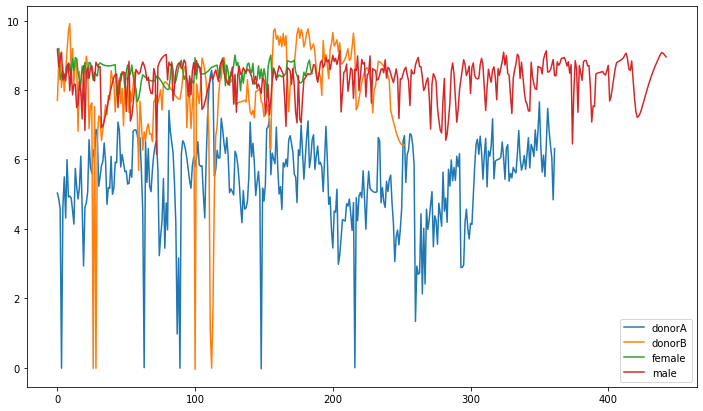

In [1309]:
for k in data_raw.keys():
    df_clr[k][covs_score_best[k][0]].plot(label=k, legend=True, figsize=(12, 7))
plt.show()

Doesn't look great... Maybe we should choose one bacterium for all datasets?

#### Choose as reference bacterium the one that appeared most frequantly as the best one in all datasetes

In [1310]:
best_bacteria = [v[0] for k, v in covs_score_best.items()]  # take all
best_bacterium = Counter(best_bacteria).most_common(1)[0][0]  # take one
print(f"Best bacterium for all datasets: {best_bacterium}\n{taxonomy.loc[best_bacterium]['Taxon']}")

Best bacterium for all datasets: TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG
k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__


#### Sanity check: is the species present in all datasets?

In [1311]:
for k in data_raw.keys():
    assert best_bacterium in nonzero_cols[k]

#### Again, how best bacterium change in time?

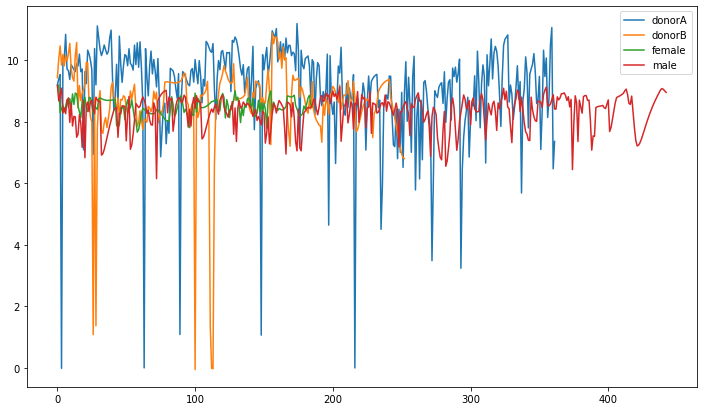

In [1312]:
for k in data_raw.keys():
    df_clr[k][best_bacterium].plot(label=k, legend=True, figsize=(12, 7))
plt.show()

Hmmm... looks better on average!

#### Perform ALR transform

In [1314]:
df_alr = {}   # save values for last pseudocount entry !!!
for k in data_raw.keys():
    for pseudocount in pseudocounts:
        # Add pseudocounts
        df = filtered_df[k] + pseudocount
        # Transform dataframe
        df_alr[k] = np.log((df).div(df[best_bacterium], axis=0))
        assert (df_alr[k][best_bacterium] == 0).all()
        df_alr[k].to_csv(OUTPUT_PATH / 'filtered_transformed' /\
                      f'{k}_filtered-{treshold_perc}_pseudo-{pseudocount}_alr-1.csv')
        # Save ALR bacteria
        with open(OUTPUT_PATH  / 'ALR_bacteria.pkl', 'wb') as f:
            pickle.dump({k: best_bacterium for k in data_raw.keys()}, f)

## How pseudocount influences CLR?

- we use `male` dataset
- where first 72 timesteps come from 2008 and the rest from 2009 and 2010

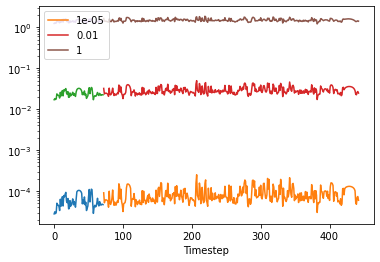

In [579]:
for pseudo in pseudocounts:
    plt.plot(range(72), gmean(data_raw['male'].iloc[:72] + pseudo, axis=1))
    plt.plot(range(72, 371+72), gmean(data_raw['male'].iloc[72:] + pseudo, axis=1), label=pseudo)
plt.legend(loc=2)
plt.yscale('log')
plt.xlabel('Timestep')
plt.show()

- character (fall/rise) is preserved
- magnitude & spread is altered sizeably

#### CLR

In [589]:
bact = [0, 1000, 19]

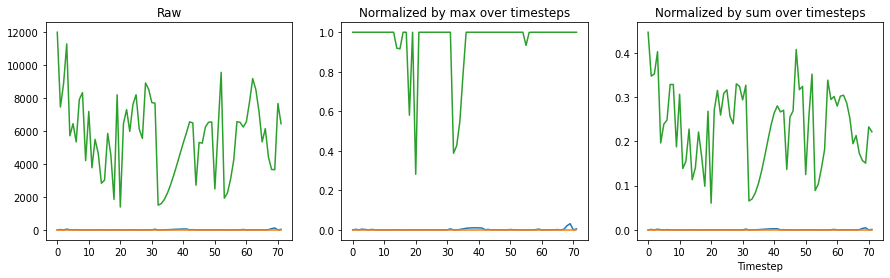

In [590]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
data_raw['male'].iloc[:72, bact].plot(legend=False, title='Raw', ax=axes[0])
data_raw['male'].div(data_raw['male'].max(axis=1), axis=0).iloc[:72, bact].plot(legend=False, 
                                                                                title='Normalized by max over timesteps', ax=axes[1])
data_raw['male'].div(data_raw['male'].sum(axis=1), axis=0).iloc[:72, bact].plot(legend=False, 
                                                                                title='Normalized by sum over timesteps', ax=axes[2])
plt.xlabel('Timestep')
plt.show()

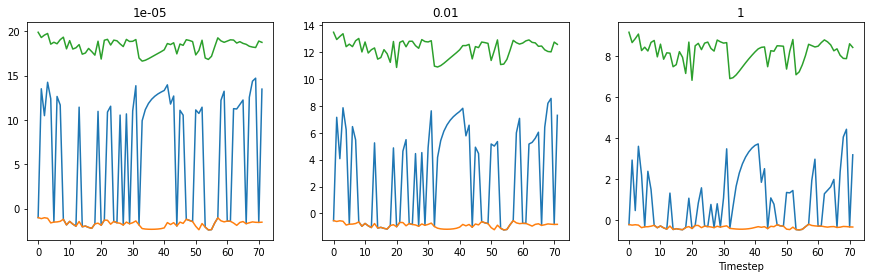

In [603]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for i, pseudo in enumerate(pseudocounts):
    np.log((data_raw['male'] + pseudo).div(gmean(data_raw['male'] + pseudo, axis=1), axis=0)).iloc[:72, bact].plot(legend=False, 
                                                                                                         title=pseudo, ax=axes[i])
plt.xlabel('Timestep')
plt.show()

Again:
- character (fall/rise) is preserved
- magnitude & spread is altered sizeably

But:
- for very small pseudocounts (like 1e-5), the variability is very high and extreme values for each timesteps become similar to each other